# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                     
Sample_198  Q16620;Q16620-2;Q16620-3;Q16620-4;Q16620-5;Q16620-6   17.691
Sample_019  P61278                                                19.001
Sample_103  B5MBX2;F8WE86;P20062;P20062-2                         18.972
Sample_096  A0A0G2JRQ6                                            17.344
Sample_072  E7EPV7;P37840;P37840-2                                14.741
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups          
Sample_200  I3L145;P04278              15.705
Sample_033  Q9NZ08;Q9NZ08-2            14.086
Sample_160  Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.683
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.684
            A0A075B6Q5                 13.040
            A0A075B6R2                 12.482
            A0A075B6S5                 12.536
            A0A087WSY4                 12.078
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.796
            Q9UI40;Q9UI40-2            13.820
            Q9UIW2                     10.484
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.571
            Q9UP79                     13.151
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.329,15.050,16.842,19.863,15.968,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.494,19.067,...,15.528,15.576,13.995,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.976,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.623,17.705,17.039,16.039,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.081,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.530,15.345,17.084,18.708,14.249,19.433,12.237,10.667
Sample_207,15.739,16.877,15.469,16.898,14.415,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.930,11.898,12.334,12.887,11.887,12.733,12.560,12.930,13.924,13.350
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.371,19.067,16.127,...,11.578,12.228,13.470,14.401,13.312,12.530,12.124,12.106,12.733,12.246
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,14.467,12.543,12.738,14.040,11.528,11.201,14.162,13.234,12.622,12.684
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.385,12.239,12.145,13.077,13.776,11.784,12.776,12.421,12.305,12.870
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.984,13.902,12.841,13.159,11.698,11.577,13.316,13.288,12.290,12.300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.804,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 189.44it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.00it/s]

100%|██████████| 2/2 [00:00<00:00,  6.98it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.46it/s]

100%|██████████| 3/3 [00:00<00:00,  3.22it/s]

100%|██████████| 3/3 [00:00<00:00,  3.40it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.38it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.75it/s]

100%|██████████| 4/4 [00:00<00:00,  5.01it/s]

100%|██████████| 4/4 [00:00<00:00,  5.45it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.26it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.78it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.33it/s]

100%|██████████| 5/5 [00:01<00:00,  4.28it/s]

100%|██████████| 5/5 [00:01<00:00,  4.52it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.76it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.59it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.90it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.43it/s]

100%|██████████| 6/6 [00:01<00:00,  3.22it/s]

100%|██████████| 6/6 [00:01<00:00,  3.66it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.98it/s]

 43%|████▎     | 3/7 [00:00<00:01,  2.88it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.35it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.33it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.32it/s]

100%|██████████| 7/7 [00:02<00:00,  2.32it/s]

100%|██████████| 7/7 [00:02<00:00,  2.49it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.42it/s]

 38%|███▊      | 3/8 [00:00<00:01,  5.00it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.59it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.20it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.08it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.06it/s]

100%|██████████| 8/8 [00:01<00:00,  3.42it/s]

100%|██████████| 8/8 [00:01<00:00,  4.04it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.16it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.29it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.03it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.67it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.55it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.52it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.69it/s]

100%|██████████| 9/9 [00:02<00:00,  3.84it/s]

100%|██████████| 9/9 [00:02<00:00,  3.85it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.90it/s]

 30%|███       | 3/10 [00:00<00:01,  5.16it/s]

 40%|████      | 4/10 [00:00<00:01,  4.98it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.67it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.16it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.88it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.89it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.39it/s]

100%|██████████| 10/10 [00:02<00:00,  3.15it/s]

100%|██████████| 10/10 [00:02<00:00,  3.86it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.86it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.06it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.62it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.42it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.34it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.80it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.82it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  4.05it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.14it/s]

100%|██████████| 11/11 [00:02<00:00,  4.16it/s]

100%|██████████| 11/11 [00:02<00:00,  4.29it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.10it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.06it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.40it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.16it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.86it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.94it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.88it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.03it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.13it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.27it/s]

100%|██████████| 12/12 [00:02<00:00,  3.73it/s]

100%|██████████| 12/12 [00:02<00:00,  4.35it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.70it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.26it/s]

 31%|███       | 4/13 [00:00<00:01,  5.38it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.57it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.71it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.69it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.72it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.75it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.75it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.34it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.51it/s]

100%|██████████| 13/13 [00:03<00:00,  3.71it/s]

100%|██████████| 13/13 [00:03<00:00,  3.99it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.63it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.18it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.33it/s]

 36%|███▌      | 5/14 [00:00<00:01,  4.62it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.15it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.75it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.85it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.57it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.26it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.47it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.47it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.56it/s]

100%|██████████| 14/14 [00:03<00:00,  3.69it/s]

100%|██████████| 14/14 [00:03<00:00,  3.94it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.18it/s]

 20%|██        | 3/15 [00:00<00:02,  5.59it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.03it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.78it/s]

 40%|████      | 6/15 [00:01<00:02,  4.31it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.90it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.00it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.61it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.70it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.89it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.06it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  4.23it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.24it/s]

100%|██████████| 15/15 [00:03<00:00,  4.30it/s]

100%|██████████| 15/15 [00:03<00:00,  4.29it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.004      0.073 0.024          0.738 0.368       0.117   
2             0.004 0.001      0.040 0.010          0.694 0.124       0.531   
3             0.005 0.003      0.055 0.024          0.686 0.107       0.618   
4             0.007 0.004      0.078 0.027          0.702 0.110       0.630   
5             0.005 0.003      0.058 0.033          0.701 0.096       0.677   
6             0.005 0.003      0.049 0.025          0.812 0.085       0.804   
7             0.006 0.004      0.059 0.027          0.810 0.087       0.807   
8             0.007 0.003      0.076 0.026          0.807 0.087       0.801   
9             0.004 0.001      0.045 0.015          0.804 0.085       0.804   
10            0.005 0.002      0.044 0.015          0.800 0.087       0.800   
11            0.004 0.001      0.042 0.010          0.824 0.086       0.810   
12            0.004 0.001      0.036 0.005          0.824 0.085       0.824   
13            0.004 0.001      0.043 0.012          0.825 0.085       0.825   
14            0.004 0.001      0.041 0.011          0.823 0.083       0.804   
15            0.004 0.001      0.043 0.011          0.821 0.079       0.801   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.194 0.132                  0.551 0.042        0.845   
2          0.107   0.593 0.088                  0.675 0.063        0.722   
3          0.131   0.641 0.093                  0.701 0.073        0.778   
4          0.109   0.656 0.081                  0.713 0.064        0.801   
5          0.113   0.683 0.078                  0.730 0.065        0.808   
6          0.110   0.803 0.075                  0.832 0.062        0.897   
7          0.107   0.803 0.072                  0.832 0.061        0.896   
8          0.108   0.799 0.073                  0.829 0.061        0.893   
9          0.104   0.799 0.070                  0.828 0.059        0.892   
10         0.106   0.795 0.074                  0.825 0.063        0.895   
11         0.110   0.812 0.073                  0.840 0.062        0.904   
12         0.105   0.820 0.073                  0.846 0.062        0.904   
13         0.107   0.820 0.075                  0.847 0.064        0.903   
14         0.104   0.809 0.070                  0.837 0.058        0.908   
15         0.094   0.806 0.064                  0.835 0.054        0.905   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.819 0.090        210.000 0.000  
2          0.082                  0.679 0.103        210.000 0.000  
3          0.078                  0.710 0.096        210.000 0.000  
4          0.073                  0.760 0.096        210.000 0.000  
5          0.068                  0.758 0.096        210.000 0.000  
6          0.053                  0.867 0.068        210.000 0.000  
7          0.054                  0.864 0.071        210.000 0.000  
8          0.055                  0.861 0.071        210.000 0.000  
9          0.056                  0.861 0.068        210.000 0.000  
10         0.057                  0.867 0.070        210.000 0.000  
11         0.056                  0.880 0.066        210.000 0.000  
12         0.058                  0.882 0.066        210.000 0.000  
13         0.058                  0.881 0.067        210.000 0.000  
14         0.055                  0.890 0.060        210.000 0.000  
15         0.055                  0.888 0.060 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 433.47it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.32it/s]

100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.95it/s]

100%|██████████| 3/3 [00:00<00:00,  3.88it/s]

100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.09it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.96it/s]

100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

100%|██████████| 4/4 [00:01<00:00,  3.94it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.55it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.27it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.47it/s]

100%|██████████| 5/5 [00:01<00:00,  3.08it/s]

100%|██████████| 5/5 [00:01<00:00,  3.46it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.02it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.46it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.32it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.27it/s]

100%|██████████| 6/6 [00:01<00:00,  3.33it/s]

100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.50it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.23it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.42it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.14it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.99it/s]

100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

100%|██████████| 7/7 [00:01<00:00,  4.34it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.80it/s]

 38%|███▊      | 3/8 [00:00<00:00,  6.27it/s]

 50%|█████     | 4/8 [00:00<00:00,  6.12it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  6.04it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  5.78it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  5.92it/s]

100%|██████████| 8/8 [00:01<00:00,  6.01it/s]

100%|██████████| 8/8 [00:01<00:00,  6.15it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.18it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.33it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.75it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.36it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.96it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.92it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.87it/s]

100%|██████████| 9/9 [00:02<00:00,  3.91it/s]

100%|██████████| 9/9 [00:02<00:00,  4.24it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.27it/s]

 30%|███       | 3/10 [00:00<00:01,  6.44it/s]

 40%|████      | 4/10 [00:00<00:01,  5.65it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.01it/s]

 60%|██████    | 6/10 [00:01<00:00,  5.09it/s]

 70%|███████   | 7/10 [00:01<00:00,  5.28it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.08it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.90it/s]

100%|██████████| 10/10 [00:01<00:00,  4.84it/s]

100%|██████████| 10/10 [00:01<00:00,  5.23it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.37it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.37it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.63it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.44it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.50it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.44it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.43it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.29it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.59it/s]

100%|██████████| 11/11 [00:02<00:00,  4.43it/s]

100%|██████████| 11/11 [00:02<00:00,  4.61it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.61it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.63it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.79it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.64it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.58it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.36it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.21it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.00it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.78it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.85it/s]

100%|██████████| 12/12 [00:02<00:00,  3.91it/s]

100%|██████████| 12/12 [00:02<00:00,  4.29it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 12.96it/s]

 31%|███       | 4/13 [00:00<00:00,  9.69it/s]

 46%|████▌     | 6/13 [00:00<00:00,  8.80it/s]

 54%|█████▍    | 7/13 [00:00<00:00,  8.54it/s]

 62%|██████▏   | 8/13 [00:00<00:00,  8.35it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  8.21it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  8.13it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  8.06it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  8.02it/s]

100%|██████████| 13/13 [00:01<00:00,  7.96it/s]

100%|██████████| 13/13 [00:01<00:00,  8.45it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 11.88it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.60it/s]

 36%|███▌      | 5/14 [00:00<00:01,  7.06it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.70it/s]

 50%|█████     | 7/14 [00:00<00:01,  6.58it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  6.51it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  6.39it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  6.37it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  6.34it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  6.36it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  6.25it/s]

100%|██████████| 14/14 [00:02<00:00,  6.16it/s]

100%|██████████| 14/14 [00:02<00:00,  6.61it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.73it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.89it/s]

 40%|████      | 6/15 [00:00<00:01,  8.88it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.63it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.45it/s]

 60%|██████    | 9/15 [00:01<00:00,  8.31it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.20it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.12it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.03it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  7.94it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  7.92it/s]

100%|██████████| 15/15 [00:01<00:00,  7.91it/s]

100%|██████████| 15/15 [00:01<00:00,  8.45it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.045 0.013          0.188 0.352       0.022   
2             0.004 0.002      0.040 0.006          0.818 0.086       0.728   
3             0.004 0.001      0.052 0.017          0.805 0.089       0.720   
4             0.004 0.002      0.045 0.020          0.787 0.094       0.721   
5             0.005 0.002      0.057 0.021          0.780 0.097       0.721   
6             0.004 0.002      0.038 0.013          0.782 0.091       0.731   
7             0.003 0.001      0.035 0.004          0.791 0.099       0.740   
8             0.002 0.000      0.022 0.002          0.785 0.102       0.737   
9             0.003 0.000      0.035 0.002          0.803 0.097       0.751   
10            0.004 0.001      0.035 0.005          0.828 0.089       0.777   
11            0.002 0.000      0.023 0.004          0.824 0.087       0.779   
12            0.003 0.001      0.031 0.006          0.821 0.089       0.789   
13            0.002 0.000      0.021 0.001          0.825 0.094       0.798   
14            0.002 0.000      0.021 0.000          0.841 0.086       0.796   
15            0.002 0.000      0.020 0.000          0.813 0.088       0.787   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.049   0.038 0.080                  0.506 0.021        0.877   
2          0.105   0.764 0.072                  0.802 0.055        0.884   
3          0.105   0.754 0.074                  0.794 0.057        0.882   
4          0.108   0.747 0.077                  0.787 0.061        0.883   
5          0.113   0.743 0.081                  0.784 0.064        0.881   
6          0.115   0.749 0.075                  0.788 0.059        0.879   
7          0.114   0.758 0.083                  0.796 0.065        0.885   
8          0.115   0.754 0.084                  0.792 0.067        0.883   
9          0.119   0.769 0.081                  0.805 0.063        0.900   
10         0.112   0.795 0.079                  0.827 0.063        0.917   
11         0.114   0.794 0.076                  0.827 0.060        0.914   
12         0.107   0.799 0.074                  0.830 0.059        0.913   
13         0.105   0.806 0.072                  0.835 0.059        0.914   
14         0.111   0.812 0.076                  0.841 0.061        0.917   
15         0.110   0.795 0.076                  0.826 0.064        0.923   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.057                  0.840 0.087        210.000 0.000  
2          0.055                  0.849 0.081        210.000 0.000  
3          0.053                  0.848 0.075        210.000 0.000  
4          0.052                  0.845 0.073        210.000 0.000  
5          0.051                  0.844 0.073        210.000 0.000  
6          0.052                  0.842 0.072        210.000 0.000  
7          0.057                  0.852 0.078        210.000 0.000  
8          0.057                  0.850 0.077        210.000 0.000  
9          0.052                  0.873 0.070        210.000 0.000  
10         0.047                  0.891 0.066        210.000 0.000  
11         0.046                  0.887 0.064        210.000 0.000  
12         0.046                  0.886 0.064        210.000 0.000  
13         0.048                  0.887 0.068        210.000 0.000  
14         0.045                  0.892 0.064        210.000 0.000  
15         0.044                  0.902 0.058 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1312.36it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 66.18it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 47.92it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 43.33it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 40.57it/s]

100%|██████████| 5/5 [00:00<00:00, 40.41it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 42.28it/s]

100%|██████████| 6/6 [00:00<00:00, 40.76it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 44.26it/s]

100%|██████████| 7/7 [00:00<00:00, 39.93it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 40.86it/s]

100%|██████████| 8/8 [00:00<00:00, 38.66it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 41.87it/s]

100%|██████████| 9/9 [00:00<00:00, 38.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 41.24it/s]

100%|██████████| 10/10 [00:00<00:00, 36.04it/s]

100%|██████████| 10/10 [00:00<00:00, 36.68it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 41.51it/s]

 91%|█████████ | 10/11 [00:00<00:00, 37.07it/s]

100%|██████████| 11/11 [00:00<00:00, 37.33it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 42.73it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 36.94it/s]

100%|██████████| 12/12 [00:00<00:00, 36.79it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 41.20it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 35.89it/s]

100%|██████████| 13/13 [00:00<00:00, 35.49it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 41.24it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 36.06it/s]

100%|██████████| 14/14 [00:00<00:00, 34.83it/s]

100%|██████████| 14/14 [00:00<00:00, 35.60it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 41.65it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 35.87it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 34.34it/s]

100%|██████████| 15/15 [00:00<00:00, 35.07it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.020 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.020 0.000          0.653 0.134       0.478   
3             0.002 0.000      0.020 0.000          0.686 0.086       0.583   
4             0.002 0.000      0.020 0.000          0.704 0.090       0.618   
5             0.002 0.000      0.020 0.000          0.719 0.104       0.634   
6             0.002 0.000      0.020 0.001          0.689 0.105       0.645   
7             0.002 0.000      0.020 0.001          0.689 0.089       0.616   
8             0.002 0.000      0.020 0.000          0.686 0.100       0.656   
9             0.002 0.000      0.020 0.001          0.681 0.096       0.648   
10            0.002 0.000      0.020 0.000          0.676 0.101       0.634   
11            0.002 0.000      0.020 0.001          0.687 0.102       0.642   
12            0.002 0.000      0.020 0.001          0.685 0.103       0.635   
13            0.002 0.000      0.021 0.000          0.672 0.097       0.624   
14            0.002 0.000      0.021 0.000          0.695 0.102       0.633   
15            0.002 0.000      0.021 0.000          0.697 0.101       0.638   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.756   
2          0.107   0.545 0.099                  0.643 0.071        0.749   
3          0.103   0.626 0.081                  0.693 0.061        0.791   
4          0.098   0.653 0.077                  0.713 0.059        0.796   
5          0.111   0.667 0.086                  0.724 0.067        0.804   
6          0.110   0.661 0.086                  0.713 0.072        0.809   
7          0.095   0.646 0.076                  0.705 0.058        0.818   
8          0.113   0.667 0.094                  0.718 0.076        0.822   
9          0.104   0.660 0.088                  0.712 0.071        0.820   
10         0.104   0.651 0.092                  0.706 0.073        0.816   
11         0.115   0.659 0.093                  0.714 0.072        0.818   
12         0.114   0.655 0.095                  0.711 0.073        0.815   
13         0.103   0.643 0.087                  0.700 0.070        0.809   
14         0.106   0.658 0.088                  0.714 0.072        0.816   
15         0.109   0.661 0.089                  0.716 0.072        0.813   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.690 0.089        210.000 0.000  
2          0.077                  0.684 0.085        210.000 0.000  
3          0.066                  0.729 0.082        210.000 0.000  
4          0.066                  0.744 0.080        210.000 0.000  
5          0.066                  0.771 0.073        210.000 0.000  
6          0.065                  0.774 0.074        210.000 0.000  
7          0.065                  0.780 0.076        210.000 0.000  
8          0.064                  0.787 0.072        210.000 0.000  
9          0.064                  0.782 0.071        210.000 0.000  
10         0.063                  0.775 0.071        210.000 0.000  
11         0.065                  0.779 0.075        210.000 0.000  
12         0.064                  0.776 0.073        210.000 0.000  
13         0.064                  0.772 0.073        210.000 0.000  
14         0.063                  0.774 0.077        210.000 0.000  
15         0.062                  0.771 0.074 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,1,5,15
score_time,4,5,13
test_precision,13,14,5
test_recall,13,13,8
test_f1,13,14,5
test_balanced_accuracy,13,14,5
test_roc_auc,14,15,8
test_average_precision,14,15,8
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.55it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.98it/s]

 40%|████      | 6/15 [00:00<00:00,  9.12it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.79it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.55it/s]

 60%|██████    | 9/15 [00:00<00:00,  8.37it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.25it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.14it/s]

 80%|████████  | 12/15 [00:01<00:00,  8.05it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.06it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.03it/s]

100%|██████████| 15/15 [00:01<00:00,  8.01it/s]

100%|██████████| 15/15 [00:01<00:00,  8.54it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 40.75it/s]

100%|██████████| 8/8 [00:00<00:00, 36.99it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 17.82it/s]

 29%|██▊       | 4/14 [00:00<00:00, 12.07it/s]

 43%|████▎     | 6/14 [00:00<00:00, 10.93it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 10.49it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 10.28it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  9.95it/s]

100%|██████████| 14/14 [00:01<00:00,  9.76it/s]

100%|██████████| 14/14 [00:01<00:00, 10.37it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


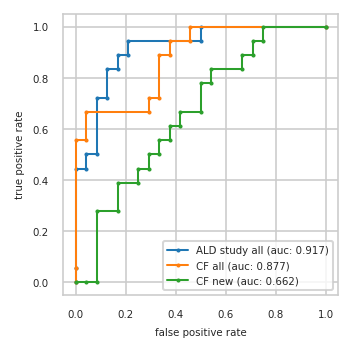

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.444  0.000 0.556  0.083 0.000
3          0.042 0.444  0.042 0.556  0.083 0.278
4          0.042 0.500  0.042 0.667  0.167 0.278
5          0.083 0.500  0.292 0.667  0.167 0.389
6          0.083 0.722  0.292 0.722  0.250 0.389
7          0.125 0.722  0.333 0.722  0.250 0.444
8          0.125 0.833  0.333 0.889  0.292 0.444
9          0.167 0.833  0.375 0.889  0.292 0.500
10         0.167 0.889  0.375 0.944  0.333 0.500
11         0.208 0.889  0.458 0.944  0.333 0.556
12         0.208 0.944  0.458 1.000  0.375 0.556
13         0.500 0.944  1.000 1.000  0.375 0.611
14         0.500 1.000    NaN   NaN  0.417 0.611
15         1.000 1.000    NaN   NaN  0.417 0.667
16           NaN   NaN    NaN   NaN  0.500 0.667
17           NaN   NaN    NaN   NaN  0.500 0.778
18           NaN   NaN    NaN   NaN  0.542 0.778
19           NaN   NaN    NaN   NaN  0.542 0.833
20           NaN   NaN    NaN   NaN  0.667 0.833
21           NaN   NaN    NaN   NaN  0.667 0.889
22           NaN   NaN    NaN   NaN  0.708 0.889
23           NaN   NaN    NaN   NaN  0.708 0.944
24           NaN   NaN    NaN   NaN  0.750 0.944
25           NaN   NaN    NaN   NaN  0.750 1.000
26           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,P31321
1,H3BLU2,Q8NBI6,B1ALD9;Q15063;Q15063-3;Q15063-5
2,Q9NR34,P31946;P31946-2,A0A087WXB8;Q9Y274
3,P04075,Q9Y2T3;Q9Y2T3-3,Q14894
4,P61981,P15151-2,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3
5,P14174,P61981,P51674;P51674-2;P51674-3
6,Q9Y2T3;Q9Y2T3-3,C9JF17;P05090,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
7,P63104,P04075,P05556;P05556-2;P05556-3;P05556-4;P05556-5
8,C9JF17;P05090,P63104,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


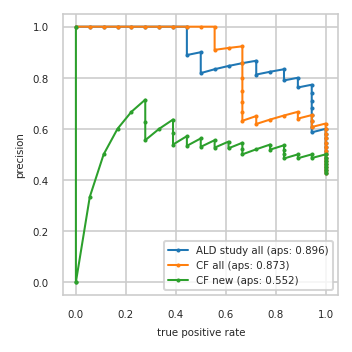

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.581 1.000     0.581 1.000     0.484 0.833
12         0.600 1.000     0.600 1.000     0.500 0.833
13         0.586 0.944     0.621 1.000     0.517 0.833
14         0.607 0.944     0.607 0.944     0.536 0.833
15         0.630 0.944     0.630 0.944     0.519 0.778
16         0.654 0.944     0.654 0.944     0.538 0.778
17         0.680 0.944     0.640 0.889     0.520 0.722
18         0.708 0.944     0.667 0.889     0.500 0.667
19         0.739 0.944     0.652 0.833     0.522 0.667
20         0.773 0.944     0.636 0.778     0.545 0.667
21         0.762 0.889     0.619 0.722     0.524 0.611
22         0.800 0.889     0.650 0.722     0.550 0.611
23         0.789 0.833     0.632 0.667     0.526 0.556
24         0.833 0.833     0.667 0.667     0.556 0.556
25         0.824 0.778     0.706 0.667     0.529 0.500
26         0.812 0.722     0.750 0.667     0.562 0.500
27         0.867 0.722     0.800 0.667     0.533 0.444
28         0.857 0.667     0.857 0.667     0.571 0.444
29         0.846 0.611     0.923 0.667     0.538 0.389
30         0.833 0.556     0.917 0.611     0.583 0.389
31         0.818 0.500     0.909 0.556     0.636 0.389
32         0.900 0.500     1.000 0.556     0.600 0.333
33         0.889 0.444     1.000 0.500     0.556 0.278
34         1.000 0.444     1.000 0.444     0.625 0.278
35         1.000 0.389     1.000 0.389     0.714 0.278
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


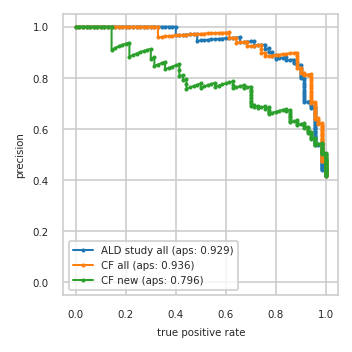

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


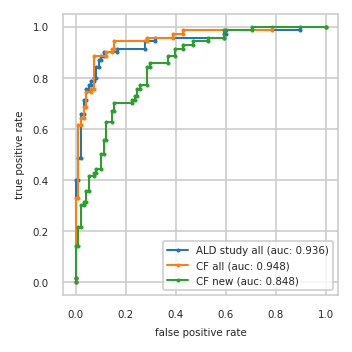

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}